In [24]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


In [25]:
# accsess the data files and dir
cancer_rays_dir     = os.listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5") 
all_rays_dir        = "all_rays_dir"  # is this path we will put all the images
cancer_rays_dir_str ="../input/breast-histopathology-images/IDC_regular_ps50_idx5/"

### what is the structure of our data?

In [26]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['10295', '10304', '12868', '10274', '12818', '14190', '12869', '9323', '10291', '12906', '9176', '8984', '10299', '12930', '9344', '12935', '12894', '12909', '9381', '9346', '9175', '10262', '8980', '16896', '12241', '12910', '13617', '13401', '12891', '10300', '9076', '10259', '9124', '13402', '12870', '16550', '10255', '9261', '15471', '12931', '12955', '10258', '13461', '13023', '9260', '8957', '9035', '10268', '13403', '10288', '9262', '12911', '9319', '10254', '13616', '10253', '8974', '9135', '10257', '9291', '9320', '14209', '14078', '12749', '9043', '9041', '8975', '9075', '13025', '13021', '13458', '12901', '16552', '13688', '15902', '13692', '12879', '9073', '15514', '9325', '10277', '12810', '8864', '8917', '14305', '16167', '13022', '16555', '12932', '14189', '8867', '16166', '10290', '9083', '15840', '12907', '12880', '12908', '13693', '13591', '15516', '9228', '14192', '12949', '10306', '9345', '14156', '12872', '9123', '13019', '9226', '14304', '10260', '14154', '15472'

##### We can see 279 files for each patient named with their id, and each file contains x-ray images of its owner

### To facilitate the process of dealing with screening mammograms images, we will collect all the images in one place, while retaining ownership of each image and its class as well...

In [27]:
import os

all_rays_dir = 'all_rays_dir'
os.makedirs(all_rays_dir, exist_ok=True)



In [28]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 

In [29]:
#Here we will move the images, but by adding a small part in their path, which indicates that they are negative or positive
for patient in cancer_rays_dir:   
    path_0 = cancer_rays_dir_str + str(patient) + '/0'
    path_1 = cancer_rays_dir_str + str(patient) + '/1'
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_rays_dir, fname)
            shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [30]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

277524

##### Now we have 277,524 images, what a number!

### Then, it's time to put images in a data_frame for easy access:

In [31]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()


image_id
0    9325_idx5_x2201_y351_class0.png
1  12906_idx5_x1501_y1751_class1.png
2   10292_idx5_x2851_y551_class0.png
3    9177_idx5_x2651_y651_class0.png
4  10308_idx5_x1351_y2601_class0.png

In [32]:
#Based on the addition that we added earlier in the path, we divide the data
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0    9325_idx5_x2201_y351_class0.png      0
1  12906_idx5_x1501_y1751_class1.png      1
2   10292_idx5_x2851_y551_class0.png      0
3    9177_idx5_x2651_y651_class0.png      0
4  10308_idx5_x1351_y2601_class0.png      0
5   9181_idx5_x1551_y1151_class0.png      0
6    9382_idx5_x151_y1851_class0.png      0
7    8955_idx5_x1151_y951_class1.png      1
8   16569_idx5_x351_y1251_class1.png      1
9  15634_idx5_x1251_y2301_class0.png      0

In [33]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0    9325_idx5_x2201_y351_class0.png      0       9325
1  12906_idx5_x1501_y1751_class1.png      1      12906
2   10292_idx5_x2851_y551_class0.png      0      10292
3    9177_idx5_x2651_y651_class0.png      0       9177
4  10308_idx5_x1351_y2601_class0.png      0      10308

In [34]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

#### It also seems that the number of healthy rays is greater than the number of infected rays, good news!

> # Exploratory Data Analysis

#### First of all, let's take a look at the nature of the mammograms...

## Healthy patches:


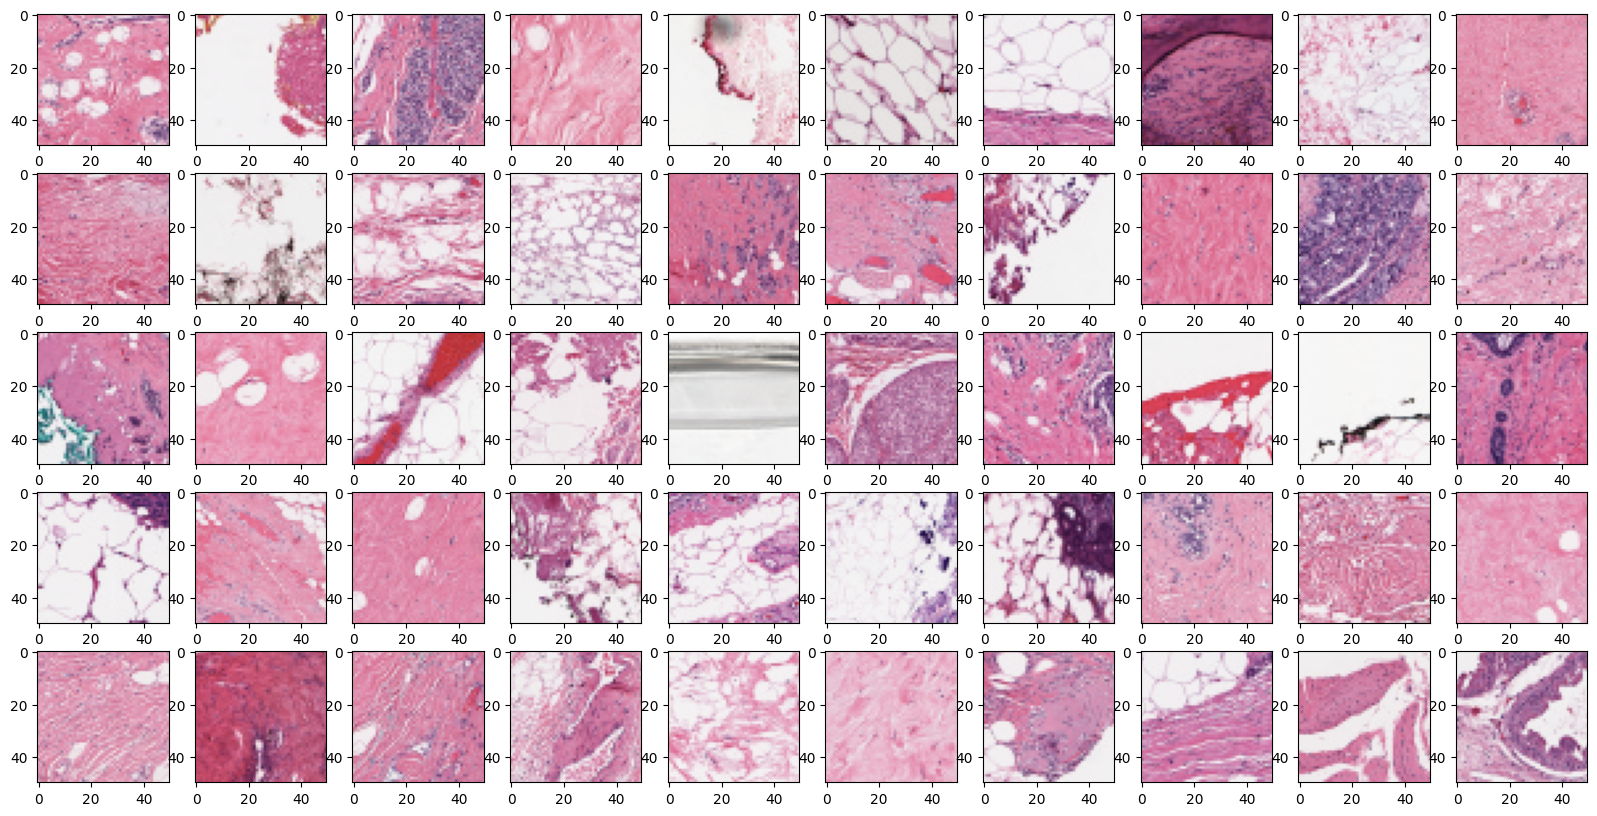

In [35]:
data.target = data.target.astype(int)  
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)




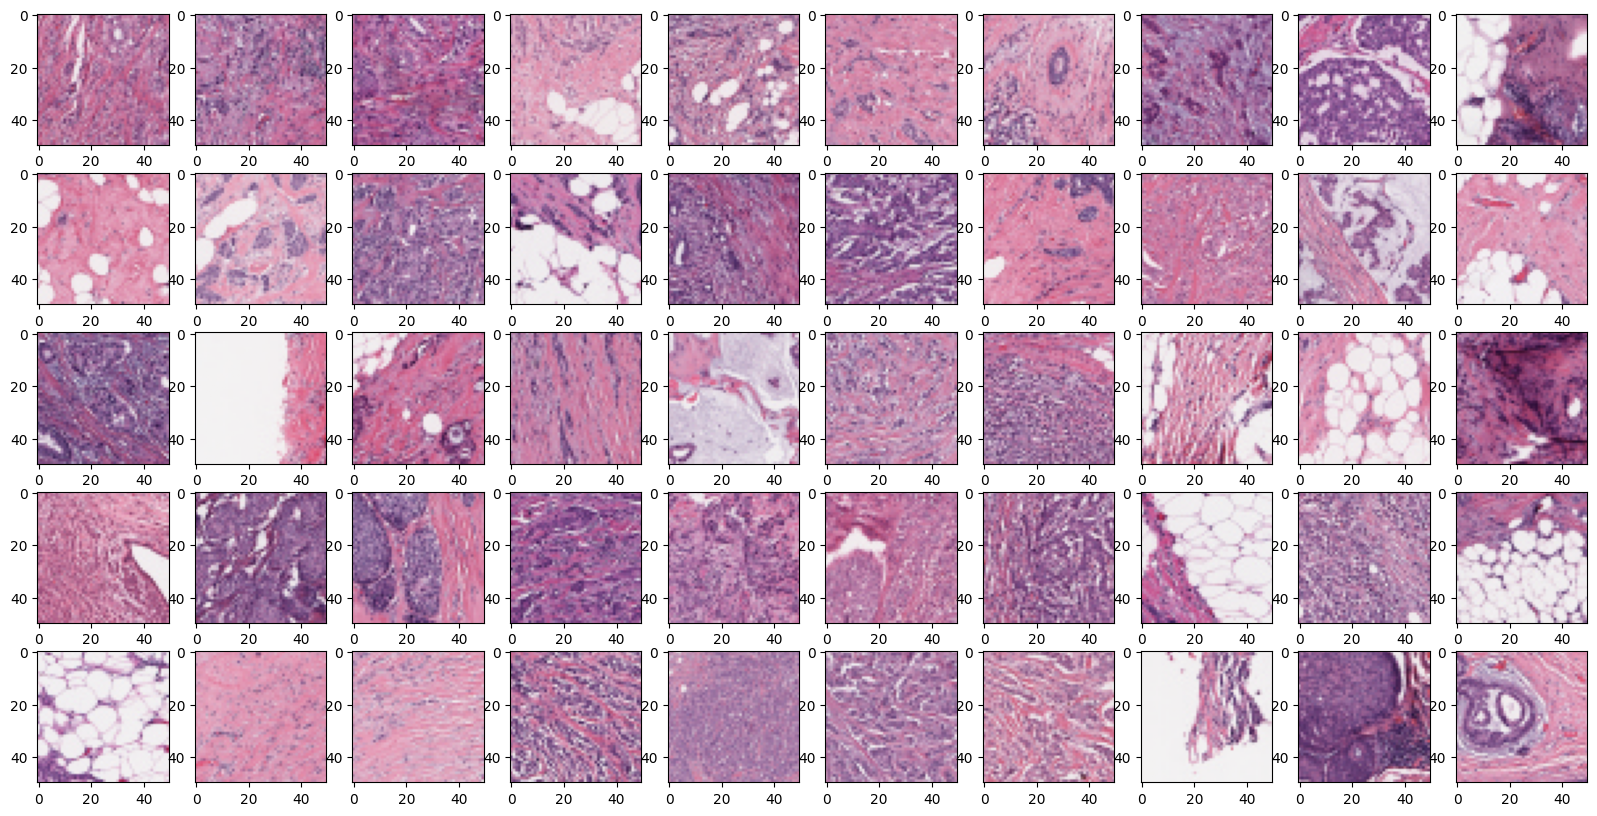

In [36]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


/tmp/ipykernel_30/1879669897.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
/tmp/ipykernel_30/1879669897.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", 

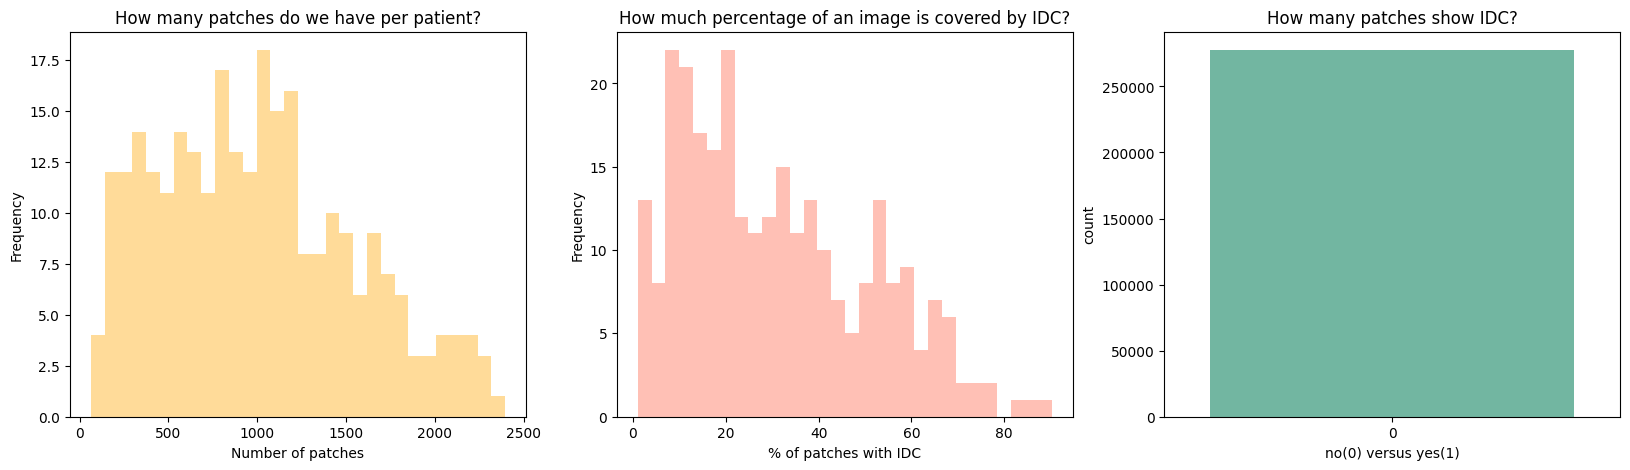

In [37]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

In [38]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)  # or np.int64(cancer_id) if specific precision is required

    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:, "x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:, "y"].str.replace("y", "", case=False).astype(int)

    return dataframe
def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)  # Use pd.concat instead of append
    return patient_df

In [39]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1201   751       0  ../input/breast-histopathology-images/IDC_regu...
1  1451   651       0  ../input/breast-histopathology-images/IDC_regu...
2  1751  1901       0  ../input/breast-histopathology-images/IDC_regu...
3  1301  1301       0  ../input/breast-histopathology-images/IDC_regu...
4   801   751       0  ../input/breast-histopathology-images/IDC_regu...

### Well let's take a closer look at the shape of the patches and their distribution in each mammogram using Binary objective visualization for each tissue slice:

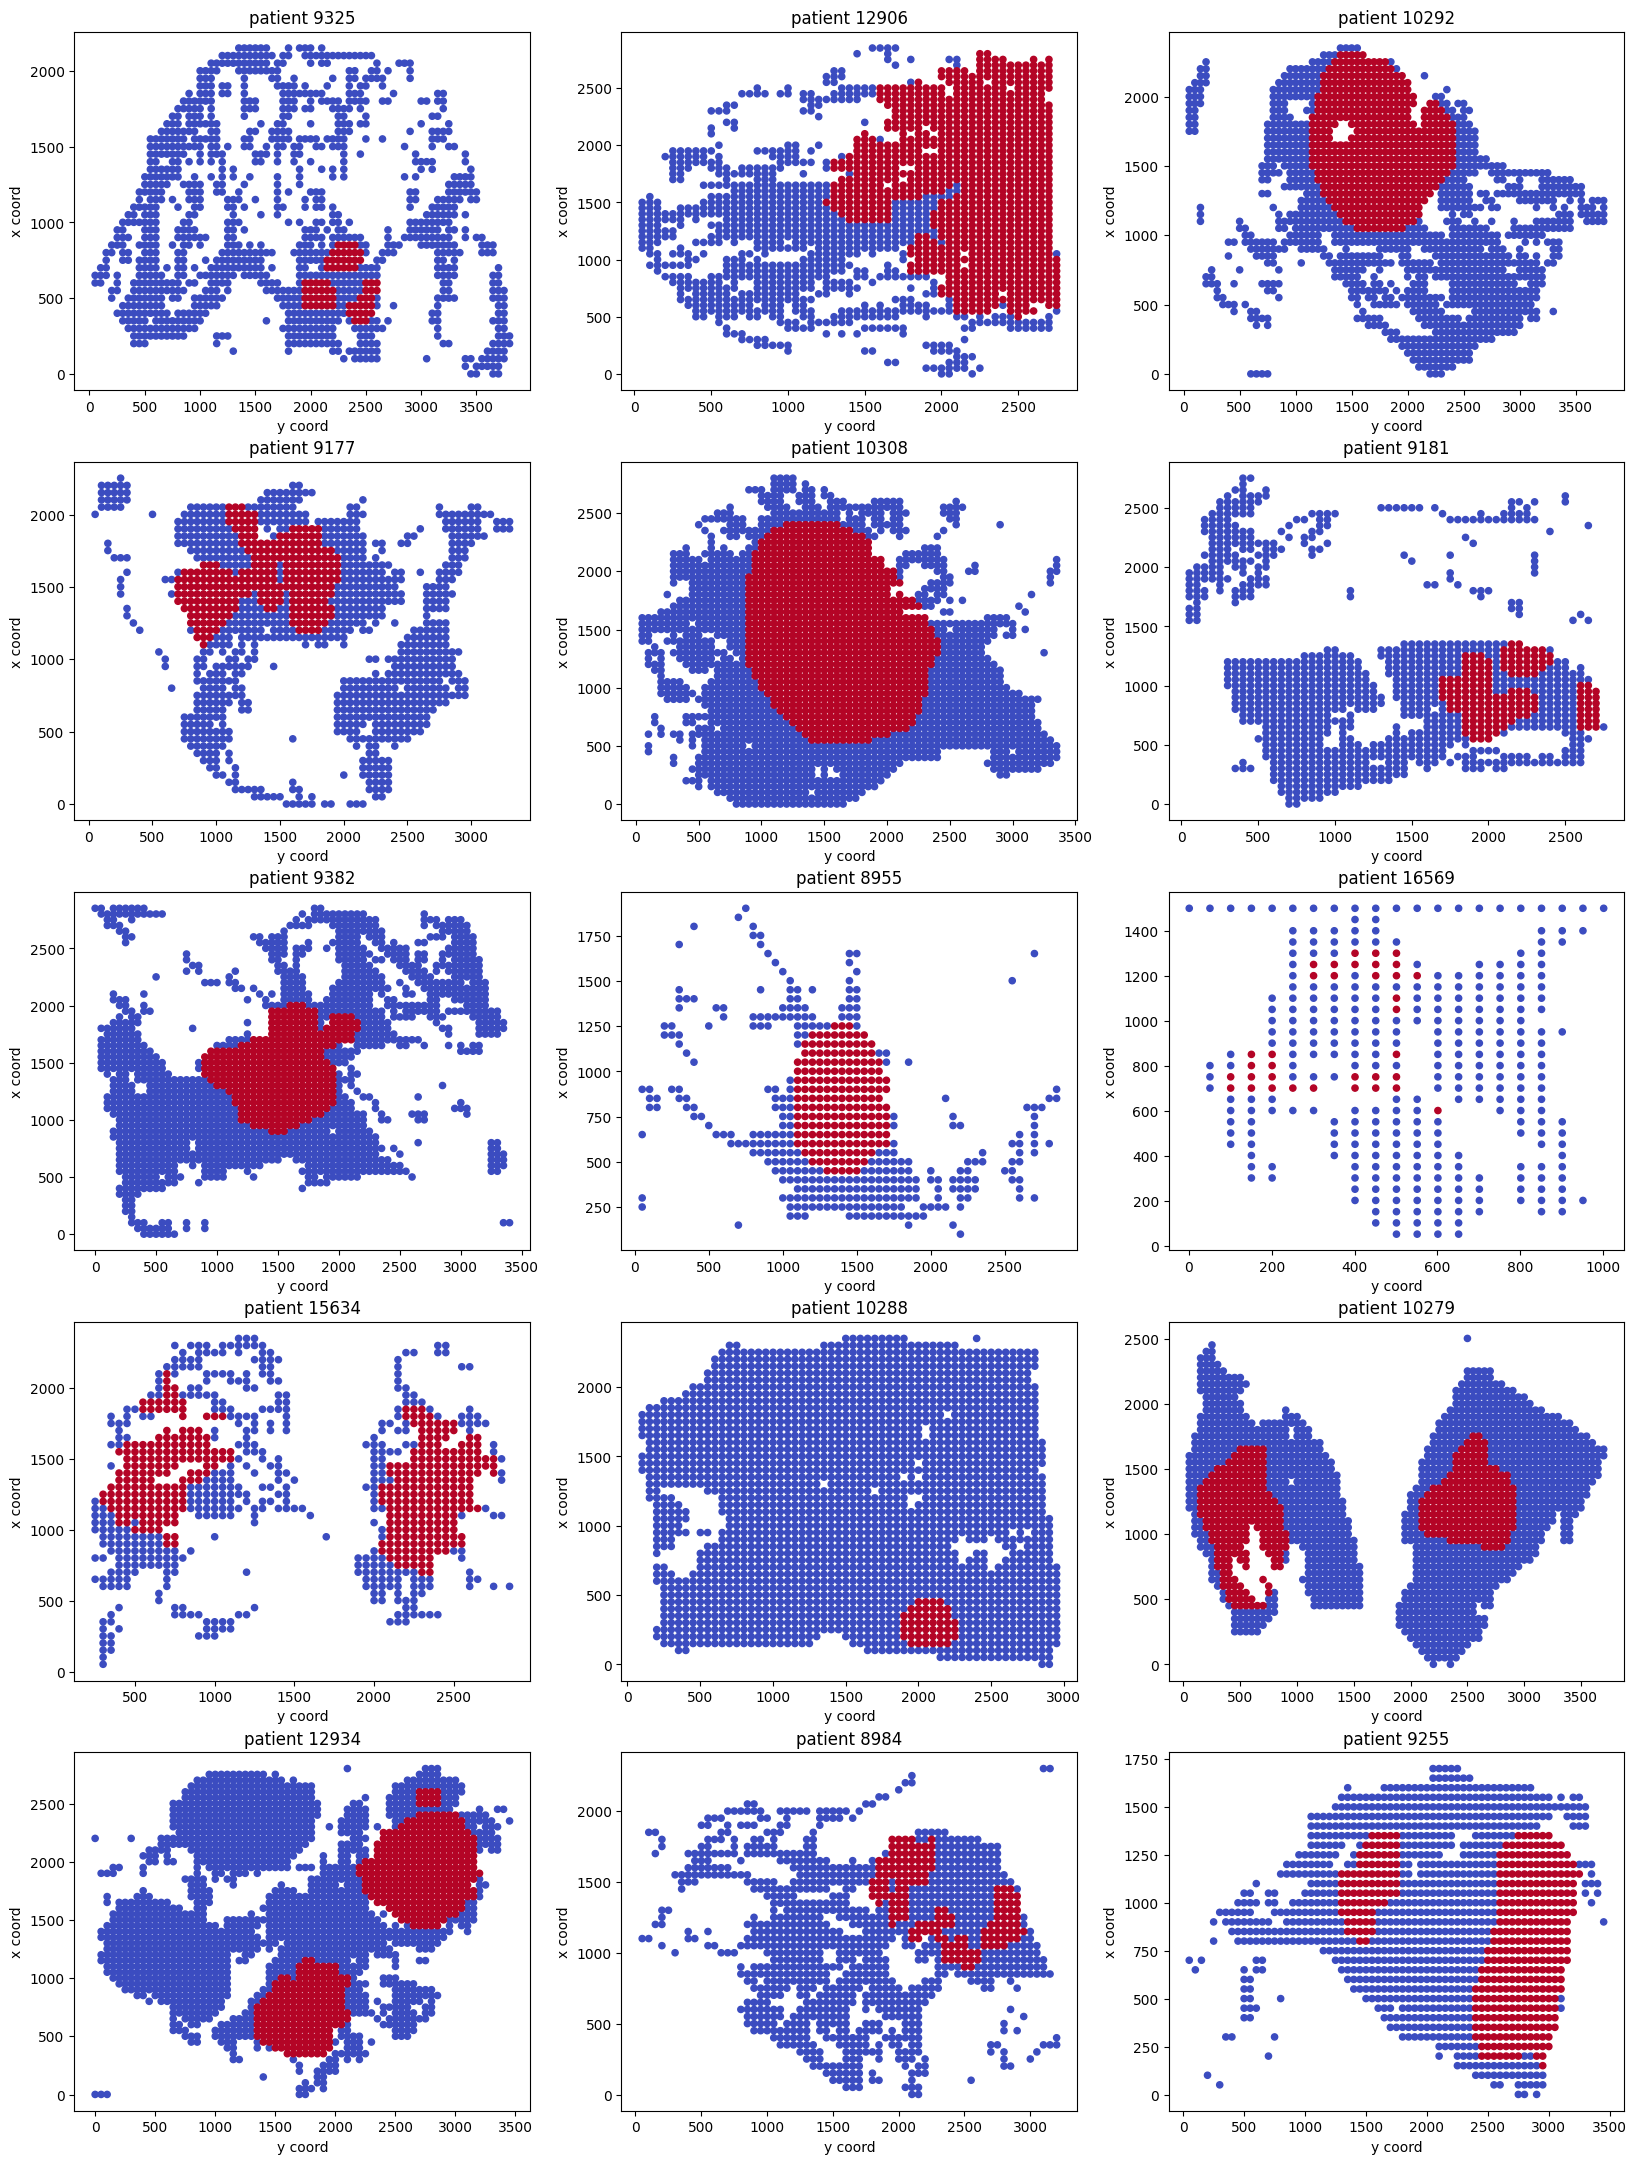

In [40]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

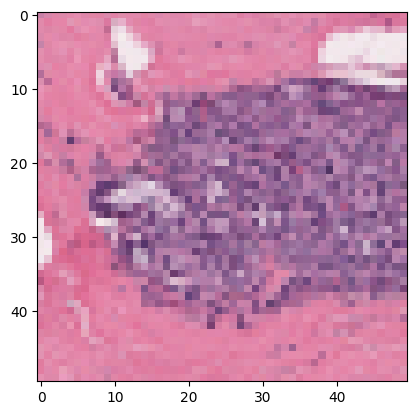

In [41]:
data.target = data.target.astype(int)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_rays_dir,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

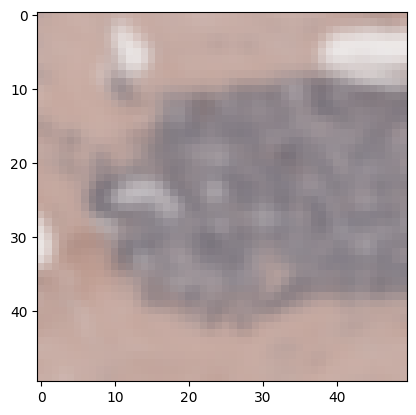

In [42]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

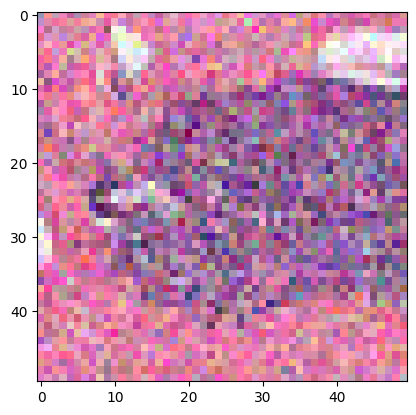

In [43]:
noise_image = random_noise(image)
plt.imshow(noise_image)

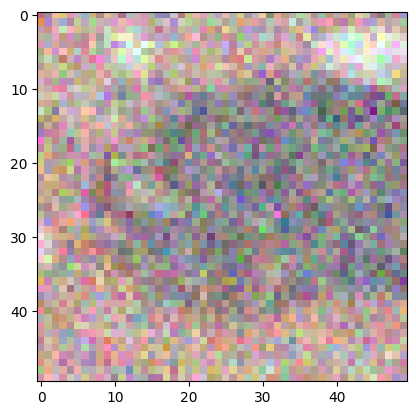

In [48]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

In [52]:
import os

# Use makedirs with exist_ok=True to avoid the error
os.makedirs('image_processing', exist_ok=True)
os.makedirs('image_processing/noise_images', exist_ok=True)


In [53]:
#Here we take the image from the normal images folder, process it, and then save it in the new file
for normal_image in all_rays_dir_lst :
    path        = all_rays_dir+'/'+ normal_image
    img         = mpimg.imread( path ,0)
    noise_image = random_noise(img)
    fname       = normal_image
    new_path    = os.path.join('image_processing/noise_images',fname)
    mpimg.imsave(new_path, noise_image)
    

In [57]:
import os

# Use os.makedirs with exist_ok=True for all directories to avoid FileExistsError
os.makedirs('image_processing/processd_data_train', exist_ok=True)
os.makedirs('image_processing/processd_data_test', exist_ok=True)
os.makedirs('image_processing/processd_data_train/zeros', exist_ok=True)
os.makedirs('image_processing/processd_data_train/ones', exist_ok=True)  # Update here
os.makedirs('image_processing/processd_data_test/zeros', exist_ok=True)
os.makedirs('image_processing/processd_data_test/ones', exist_ok=True)  # Update here


In [59]:

processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

image_id
0    9325_idx5_x2201_y351_class0.png
1  12906_idx5_x1501_y1751_class1.png
2   10292_idx5_x2851_y551_class0.png
3    9177_idx5_x2651_y651_class0.png
4  10308_idx5_x1351_y2601_class0.png

In [60]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0    9325_idx5_x2201_y351_class0.png      0
1  12906_idx5_x1501_y1751_class1.png      1
2   10292_idx5_x2851_y551_class0.png      0
3    9177_idx5_x2651_y651_class0.png      0
4  10308_idx5_x1351_y2601_class0.png      0
5   9181_idx5_x1551_y1151_class0.png      0
6    9382_idx5_x151_y1851_class0.png      0
7    8955_idx5_x1151_y951_class1.png      1
8   16569_idx5_x351_y1251_class1.png      1
9  15634_idx5_x1251_y2301_class0.png      0

In [61]:
processd_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

In [62]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [63]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)


In [64]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [65]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

178864
70907
19874
7879


In [66]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0    9325_idx5_x2201_y351_class0.png      0
1  12906_idx5_x1501_y1751_class1.png      1
2   10292_idx5_x2851_y551_class0.png      0
3    9177_idx5_x2651_y651_class0.png      0
4  10308_idx5_x1351_y2601_class0.png      0
5   9181_idx5_x1551_y1151_class0.png      0
6    9382_idx5_x151_y1851_class0.png      0
7    8955_idx5_x1151_y951_class1.png      1
8   16569_idx5_x351_y1251_class1.png      1
9  15634_idx5_x1251_y2301_class0.png      0

In [67]:
os.mkdir( 'image_processing/model_tst')
os.mkdir( 'image_processing/model_tst/trainig')
os.mkdir( 'image_processing/model_tst/testing')          
os.mkdir( 'image_processing/model_tst/trainig/zeros')
os.mkdir( 'image_processing/model_tst/trainig/ones')
os.mkdir( 'image_processing/model_tst/testing/zeros')
os.mkdir( 'image_processing/model_tst/testing/ones')

In [68]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


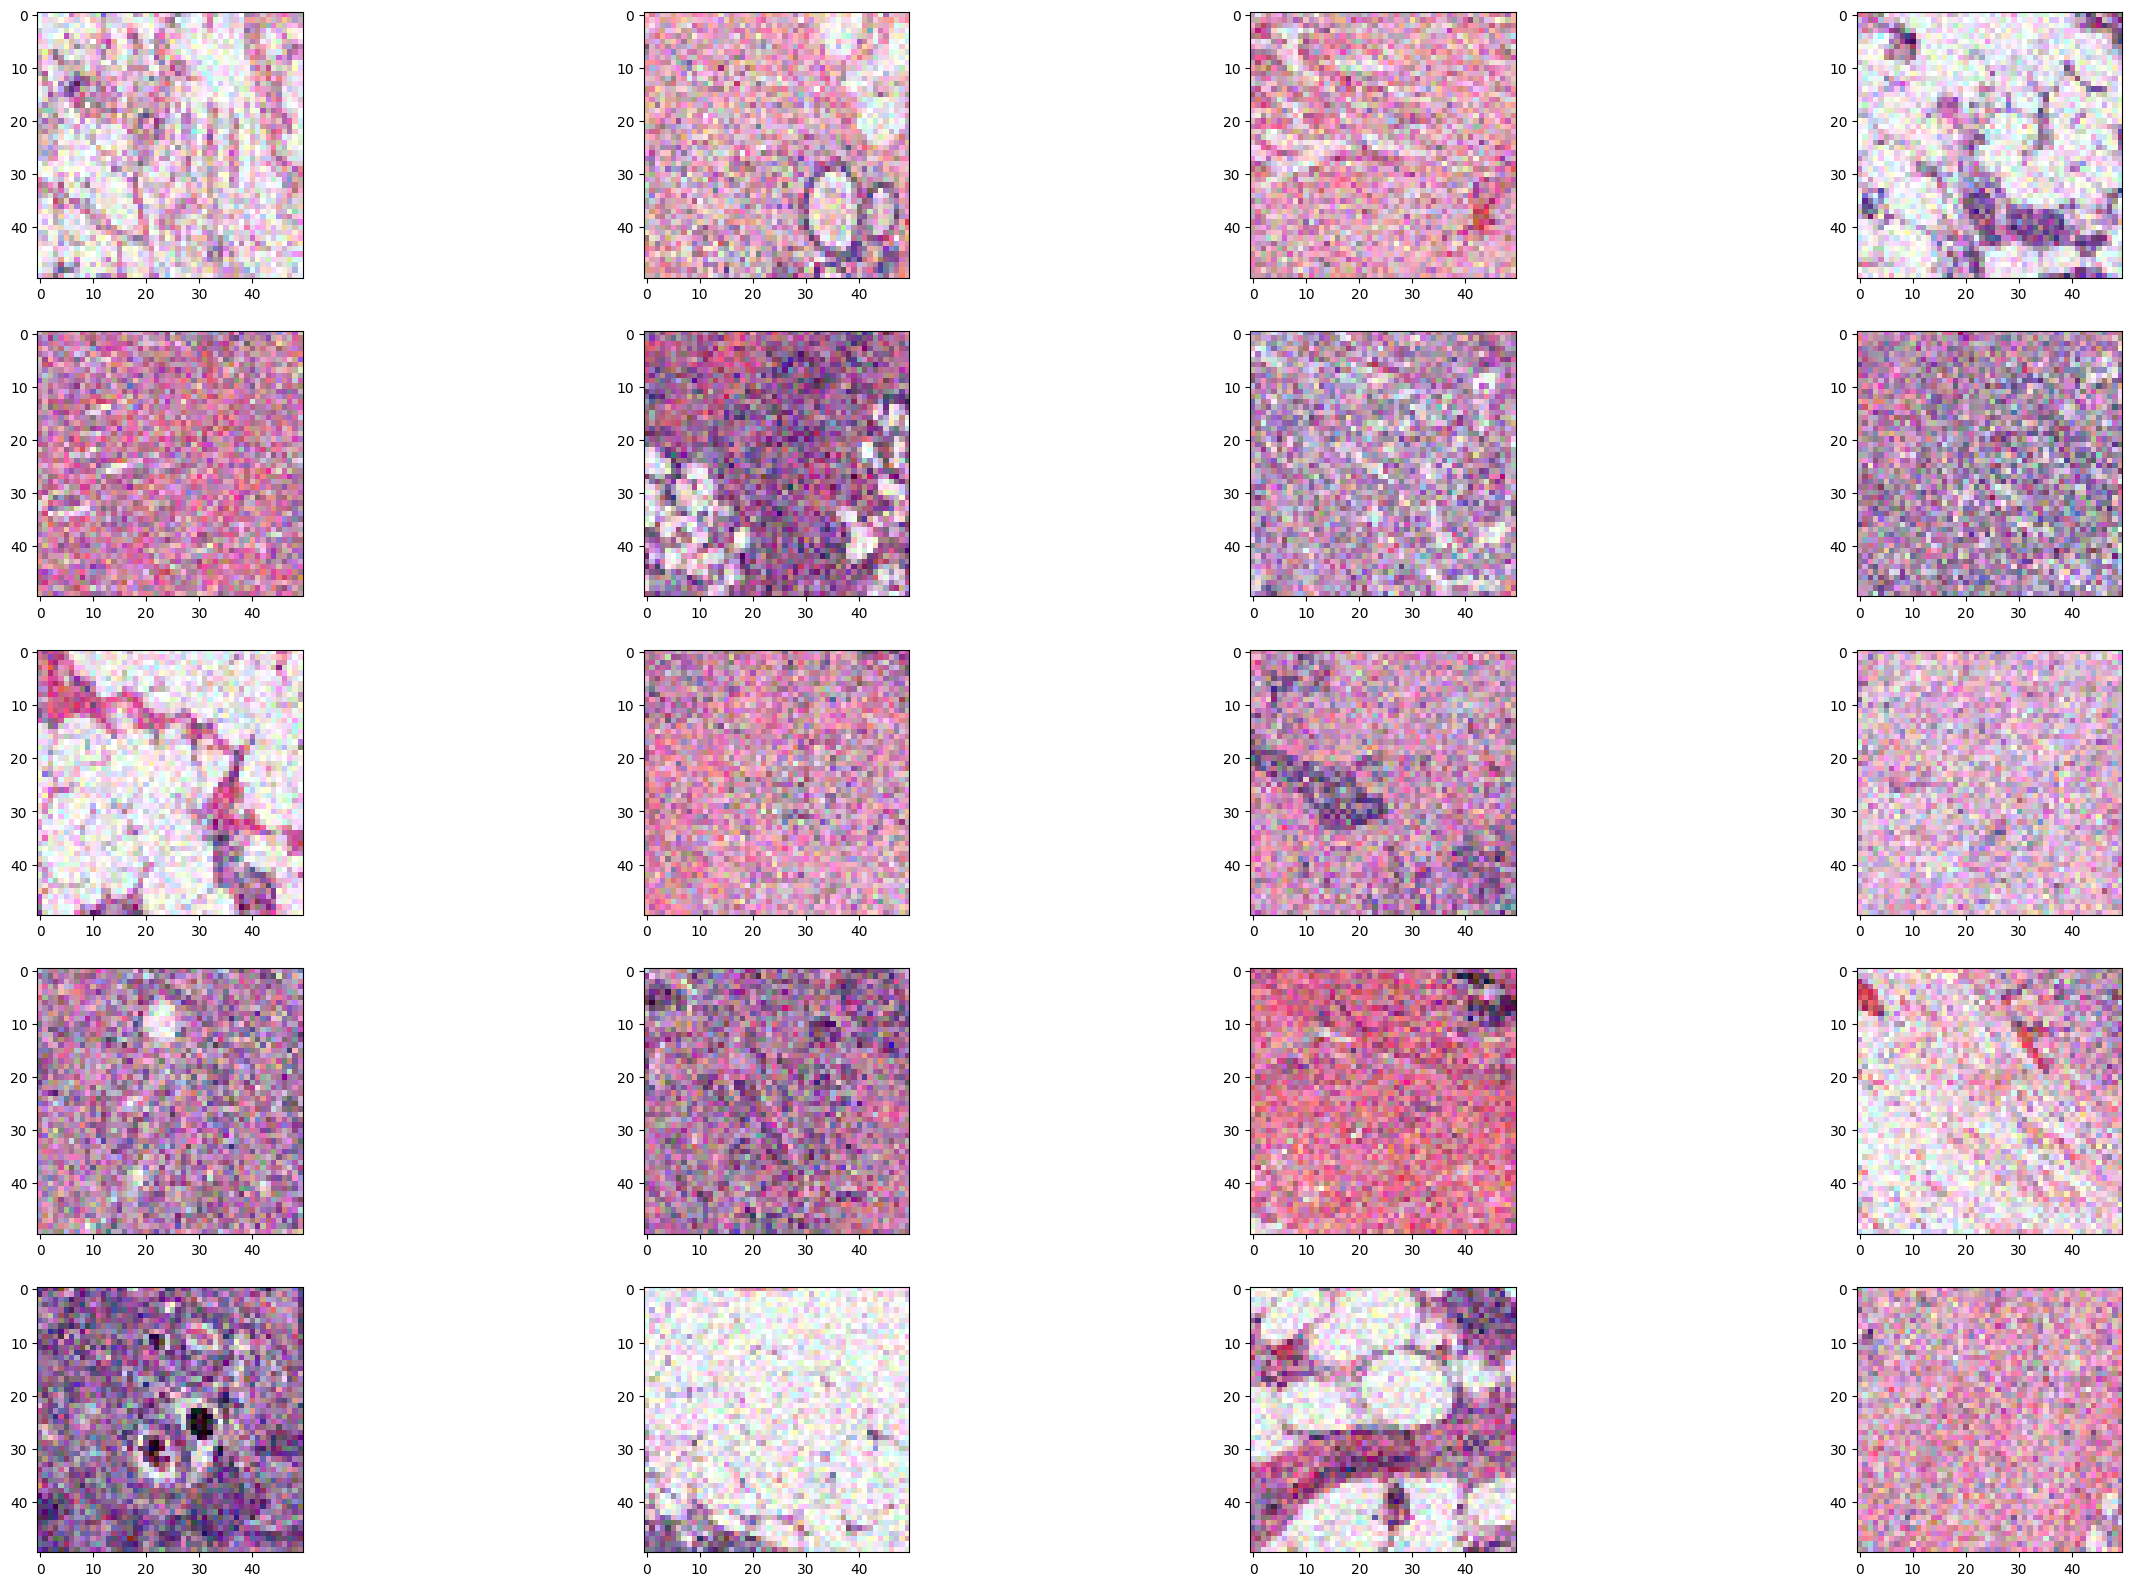

In [69]:
processd_data.target = processd_data.target.astype(int)  # Use built-in int instead of np.int
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the processed carcinogenic images

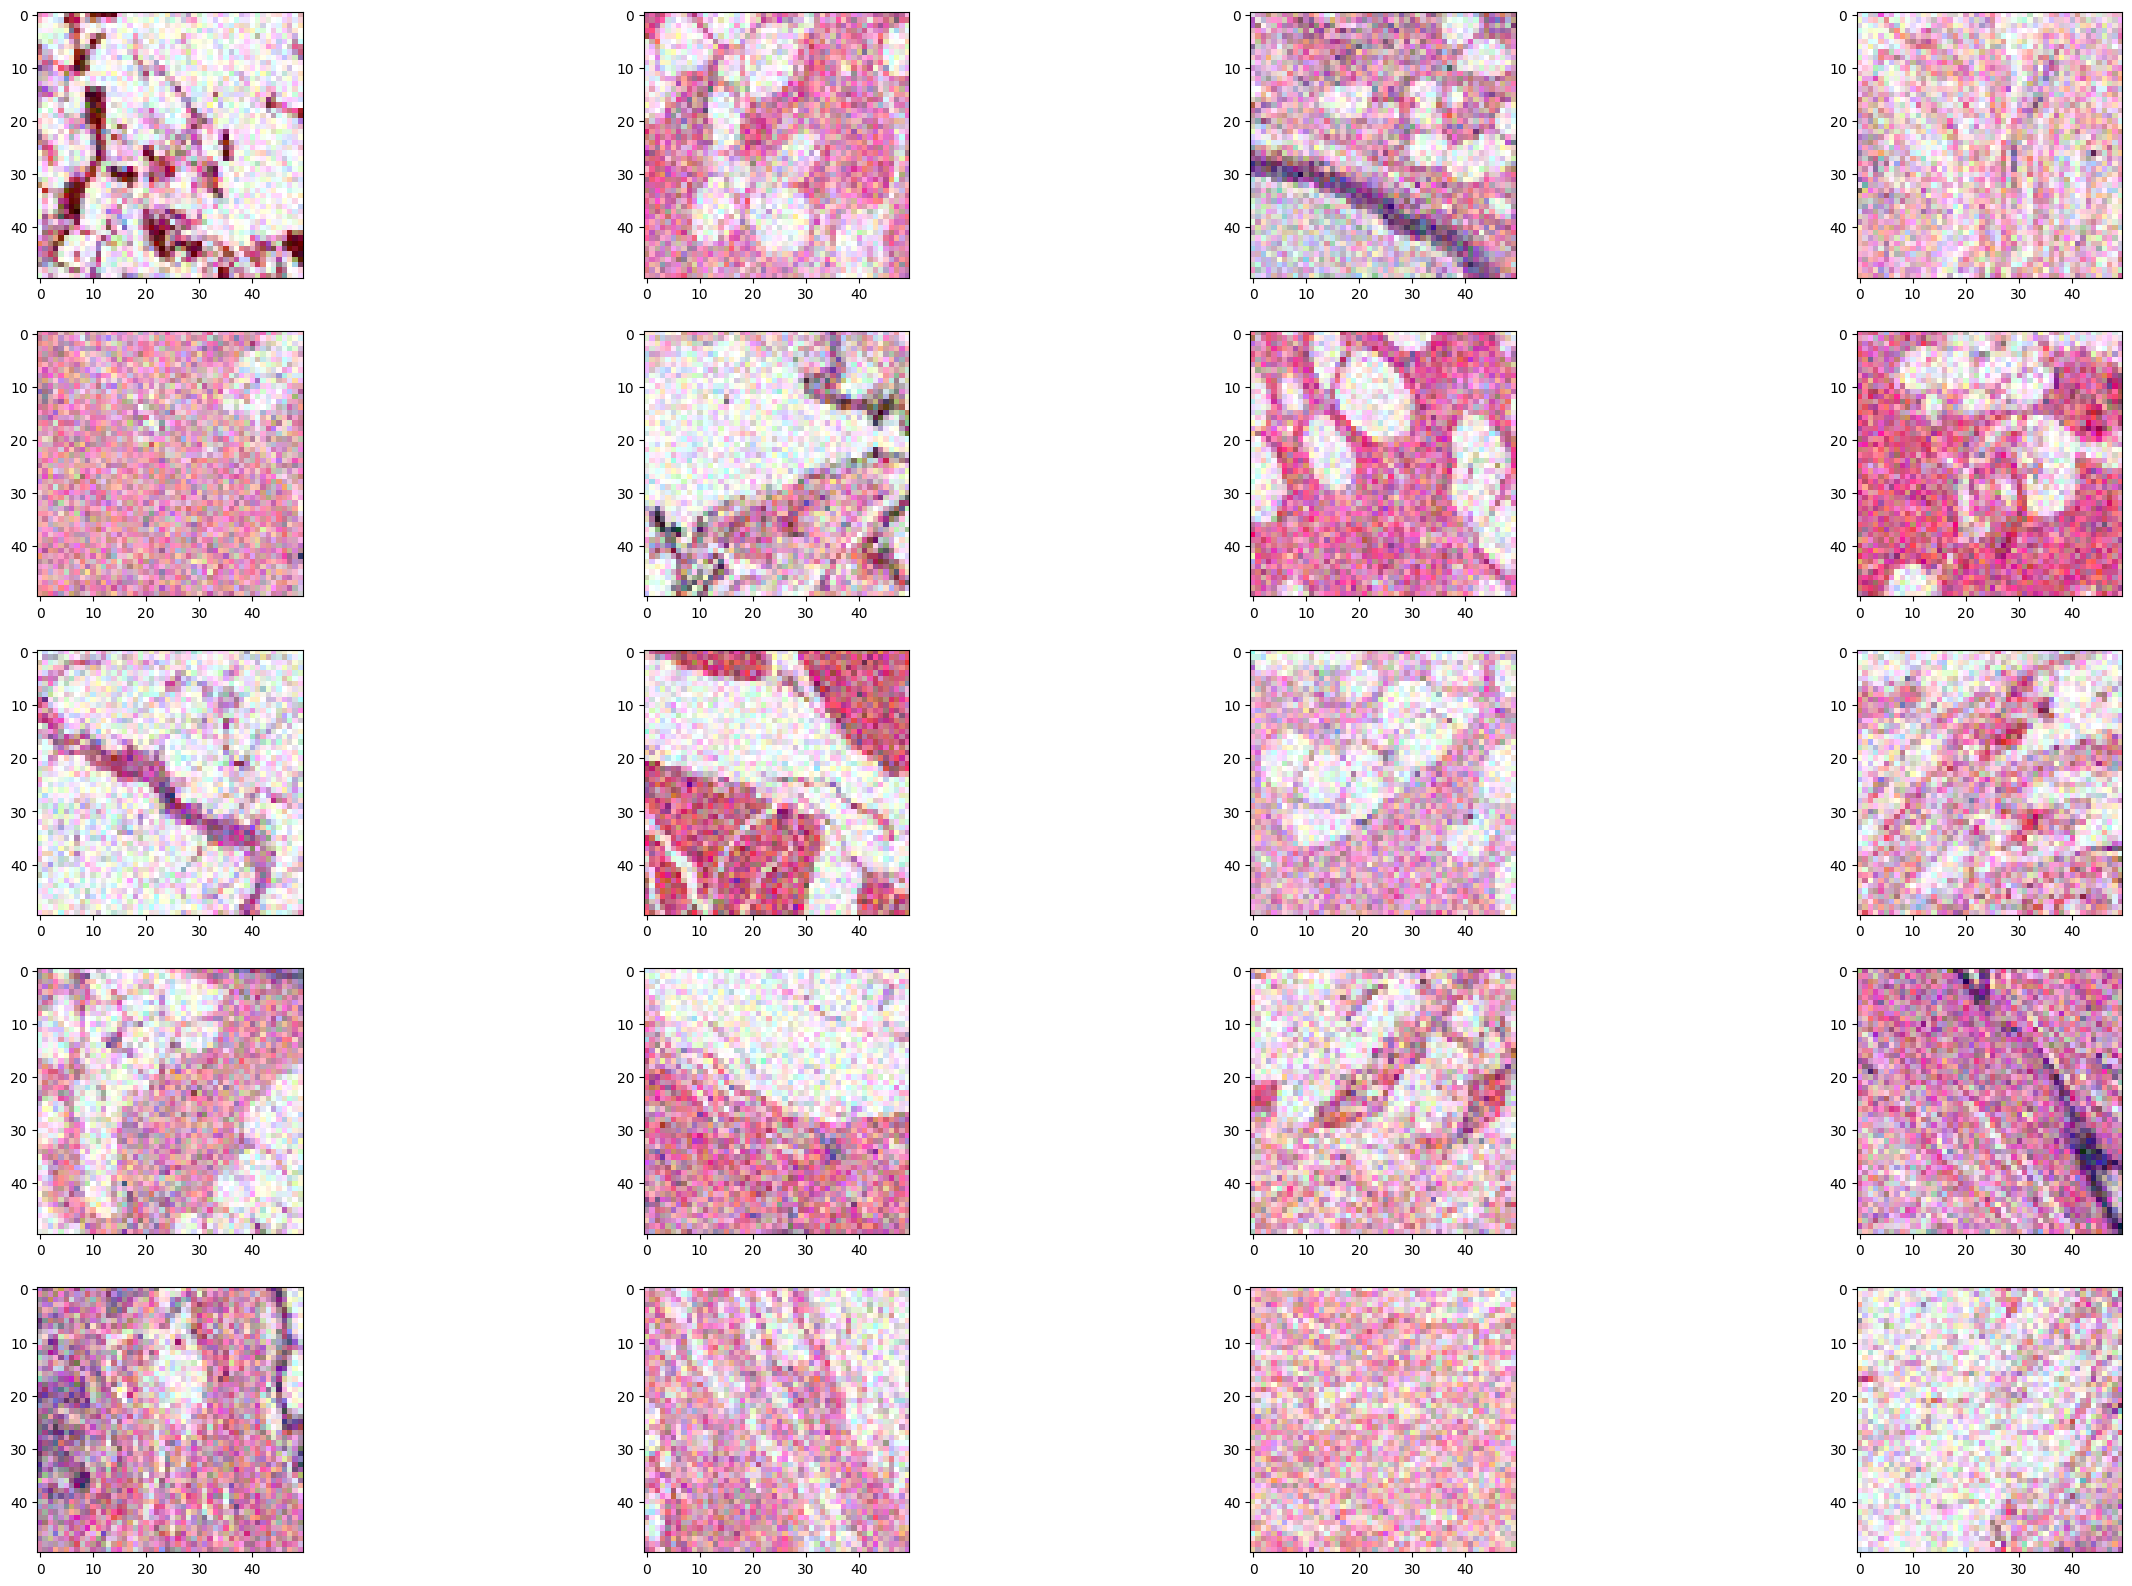

In [70]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the normal images that have been processed

In [71]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [72]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
my_model_im_processd.fit(train_generation_processd, 
                          validation_data=test_generation_processd, 
                          epochs=20, 
                          verbose=1, 
                          callbacks=[early_stop])  # Note: callbacks should be in a list


Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - accuracy: 0.7720 - loss: 0.4966 - val_accuracy: 0.7890 - val_loss: 0.4841
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7897 - loss: 0.4662 - val_accuracy: 0.8015 - val_loss: 0.4532
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7832 - loss: 0.4762 - val_accuracy: 0.7835 - val_loss: 0.4727
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7981 - loss: 0.4558 - val_accuracy: 0.8125 - val_loss: 0.4609


### Second: the normal images

In [75]:
os.mkdir( 'image_processing/normal')
os.mkdir( 'image_processing/normal/model_tst') 
os.mkdir( 'image_processing/normal/model_tst/trainig')
os.mkdir( 'image_processing/normal/model_tst/testing')
os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [76]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


In [77]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [78]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

my_model_im_processd.fit(
    train_generation_normal,  # Your training generator
    validation_data=test_generation_normal,  # Your validation generator
    epochs=20,
    verbose=1,
    callbacks=[early_stop]  # Callbacks should be passed as a list
)


Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8159 - loss: 0.4279 - val_accuracy: 0.7880 - val_loss: 0.4947
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8235 - loss: 0.4168 - val_accuracy: 0.7945 - val_loss: 0.4520
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8357 - loss: 0.3866 - val_accuracy: 0.7745 - val_loss: 0.4915
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8421 - loss: 0.3730 - val_accuracy: 0.8090 - val_loss: 0.4663


In [82]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

image_id target
0    9325_idx5_x2201_y351_class0.png      0
1  12906_idx5_x1501_y1751_class1.png      1
2   10292_idx5_x2851_y551_class0.png      0
3    9177_idx5_x2651_y651_class0.png      0
4  10308_idx5_x1351_y2601_class0.png      0

In [83]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [84]:
print(data_train.shape)
print(data_test.shape)

(249771, 2)
(27753, 2)


In [85]:
os.mkdir( 'train_dir')
os.mkdir('test_dir')

In [86]:
os.mkdir( 'train_dir/zeros')
os.mkdir( 'train_dir/ones')

os.mkdir( 'test_dir/zeros')
os.mkdir( 'test_dir/ones')


In [87]:
train = data_train.image_id
test  = data_test.image_id

In [88]:
print(data.columns)


Index(['image_id', 'target'], dtype='object')


In [89]:
print(data.head())


                            image_id target
0    9325_idx5_x2201_y351_class0.png      0
1  12906_idx5_x1501_y1751_class1.png      1
2   10292_idx5_x2851_y551_class0.png      0
3    9177_idx5_x2651_y651_class0.png      0
4  10308_idx5_x1351_y2601_class0.png      0


In [90]:
print(data.index)

RangeIndex(start=0, stop=277524, step=1)


In [91]:
data.reset_index(inplace=True)  # This moves the index back as a column

In [92]:
print(data.columns)  # 'image_id' should now appear in the columns

Index(['index', 'image_id', 'target'], dtype='object')


In [93]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('train_dir', label, fname)
    shutil.copyfile(src, dst)

In [94]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("test_dir", label, fname)
    shutil.copyfile(src, dst)


In [95]:
print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
print('IDC train          =',len(os.listdir('train_dir/ones')))
print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
print('IDC validation     =',len(os.listdir('test_dir/ones')))

non-IDC train      = 178864
IDC train          = 70907
non-IDC validation = 19874
IDC validation     = 7879


In [96]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [97]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')



Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


># Model design

In [98]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [99]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       663,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,306 (2.60 MB)

 Trainable params: 682,306 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

my_model.fit(
    train_generation,  # Your training generator
    validation_data=test_generation,  # Your validation generator
    epochs=20,
    verbose=1,
    callbacks=[early_stop]  # Callbacks should be passed as a list
)


Epoch 1/20
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 475s 19ms/step - accuracy: 0.8428 - loss: 0.3660 - val_accuracy: 0.8493 - val_loss: 0.3657
Epoch 2/20
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 457s 18ms/step - accuracy: 0.8472 - loss: 0.3578 - val_accuracy: 0.8533 - val_loss: 0.3521
Epoch 3/20
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 456s 18ms/step - accuracy: 0.8521 - loss: 0.3482 - val_accuracy: 0.8432 - val_loss: 0.3674
Epoch 4/20
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 452s 18ms/step - accuracy: 0.8535 - loss: 0.3447 - val_accuracy: 0.8398 - val_loss: 0.3777


In [ ]:
# Predict the class probabilities for the test/validation set
y_pred = my_model.predict(test_generation)
# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)


In [ ]:
# Get the true labels from the generator
y_true = test_generation.classes  # True class labels

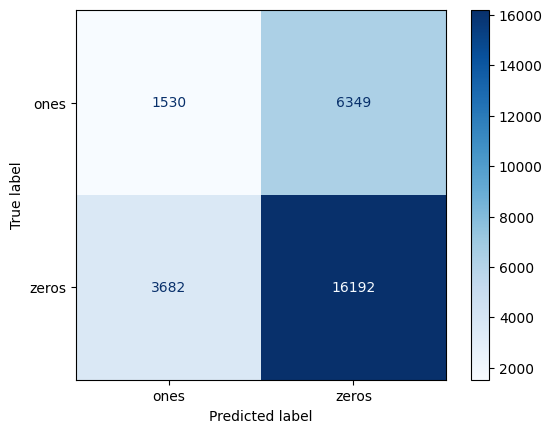

In [159]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generation.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [162]:
# Get predicted probabilities on the test/validation set
y_pred_prob = my_model.predict(test_generation)

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step


In [164]:
# Get the true labels from the generator
y_true = test_generation.classes  # True class labels

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping

In [168]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])  # Use the probabilities of the positive class
roc_auc = auc(fpr, tpr)

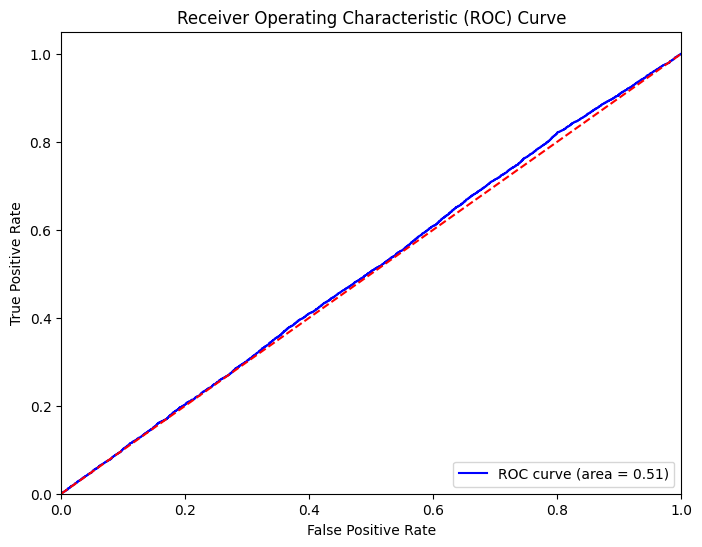

In [169]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

In [174]:
# Example data generation; replace this with your actual dataset
# X should be a 2D array of features, y should be a 1D array of labels
# For demonstration purposes, let's create some dummy data
from sklearn.datasets import make_classification

# Create a dummy dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [175]:
# Predict the class probabilities for the test/validation set
y_pred = my_model.predict(test_generation)
# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step


In [176]:
# Create a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)  # Adjust max_depth as needed

# Fit the model using the training features and labels
dt_classifier.fit(X_train, y_train)  # Use X_train for features and y_train for labels

DecisionTreeClassifier(max_depth=3, random_state=42)

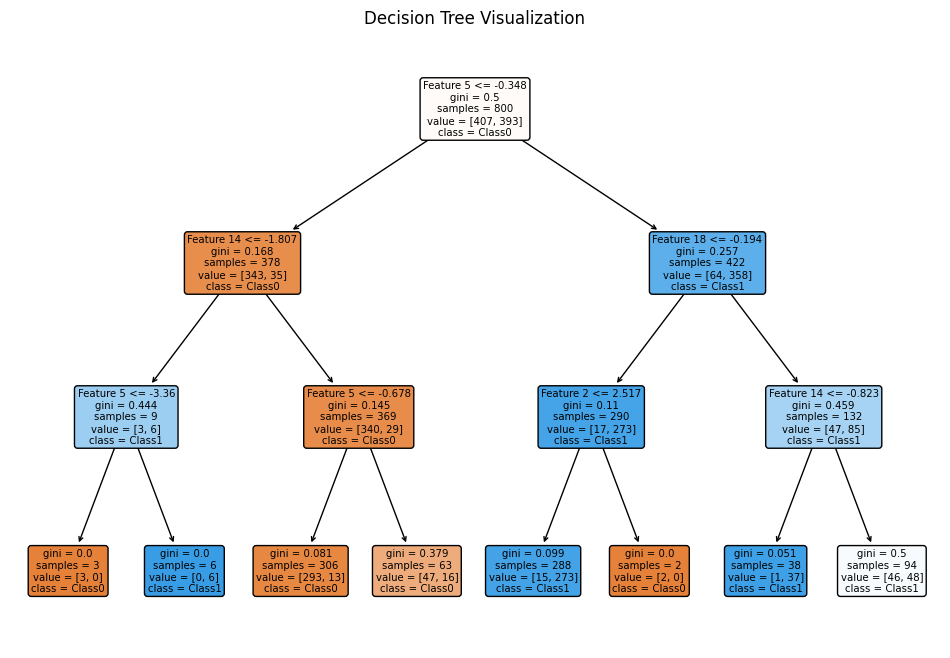

In [177]:
# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=[f'Feature {i}' for i in range(X.shape[1])],  # Adjust feature names accordingly
          class_names=['Class0', 'Class1'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

># Outputs and Outcomes

In [ ]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

<Axes: >

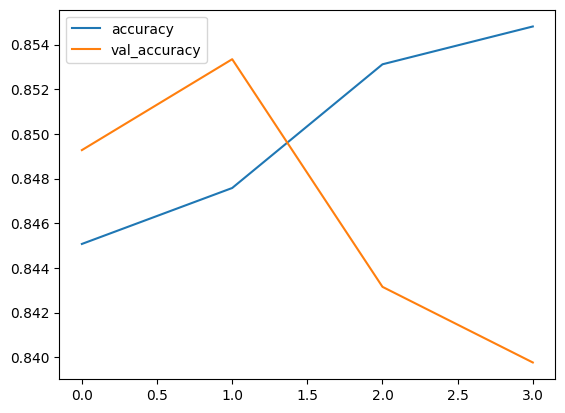

In [105]:
losse[['accuracy','val_accuracy']].plot()

In [ ]:
losse[['loss','val_loss']].plot()


In [113]:
val_loss, val_acc = my_model.evaluate(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)


2776/2776 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8392 - loss: 0.3842
val_loss: 0.37773799896240234
val_acc: 0.8397650718688965


## model results :

- After several attempts, we made a good model design
- Our model have a good acc = 85%
- over fitting is so small 
- We're ready to create APIs

> # Save &Loaded Model

In [114]:
model_json = my_model.to_json()

In [115]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)

my_model.save_weights("model.weights.h5")  # Corrected the file name
print("Saved model to disk")


Saved model to disk


In [116]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.weights.h5")  # Use the correct file name
print("Loaded model from disk")

 
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Loaded model from disk


In [142]:
import os

# List files in the current directory
print(os.listdir('.'))

['all_rays_dir', 'test_dir', 'model.weights.h5', 'image_processing', '.virtual_documents', 'model.json', 'train_dir']


In [143]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

def prediction_function(img_file_path, model, data_generation):
    # Generate data from the directory
    predict_generation = data_generation.flow_from_directory(
        img_file_path,
        target_size=(25, 25),  # Resizing images
        batch_size=10,         # Batch size for prediction
        class_mode='categorical'  # Assuming binary classification (malignant/benign)
    )

    # Make predictions
    prediction = model.predict(predict_generation)

    # Process prediction results
    malignant_percentage = round(prediction[0][0] * 100, 2)
    benign_percentage = round(prediction[0][1] * 100, 2)

    # Create readable output
    has_cancer = f'Malignant: {malignant_percentage}%'
    has_no_cancer = f'Benign: {benign_percentage}%'

    return has_cancer, has_no_cancer

def predict_single_image(model):
    # Prompt the user for the image file path
    image_path = input("Enter the full path of the image file (e.g., C:/path/to/image.jpg): ")

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(25, 25))  # Adjust size to match model input
    img_array = image.img_to_array(img)  # Convert the image to an array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Scale the pixel values

    # Make prediction
    prediction = model.predict(img_array)
    malignant_percentage = round(prediction[0][0] * 100, 2)
    benign_percentage = round(prediction[0][1] * 100, 2)

    # Create readable output
    if malignant_percentage > benign_percentage:
        diagnosis = "Malignant"
    else:
        diagnosis = "Benign"

    has_cancer = f'Malignant: {malignant_percentage}%'
    has_no_cancer = f'Benign: {benign_percentage}%'
    result = f'The prediction is: {diagnosis}'

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    return result, has_cancer, has_no_cancer

# Main function to run the predictions
def main():
    img_file_path = "image_processing/normal/model_tst/trainig"  # Path to image directory

    # Get predictions for the directory
    x, y = prediction_function(img_file_path, loaded_model, data_generation)
    print(x)  # Malignant percentage
    print(y)  # Benign percentage

    while True:
        # Ask the user for the action
        action = input("Type 'predict' to predict a single image or 'exit' to quit: ").strip().lower()

        if action == 'predict':
            result, malignant_info, benign_info = predict_single_image(loaded_model)
            print(result)          # Display if it's malignant or benign
            print(malignant_info)  # Display malignant percentage
            print(benign_info)     # Display benign percentage
        elif action == 'exit':
            print("Exiting the program.")
            break
        else:
            print("Invalid command. Please type 'predict' or 'exit'.")

# Example usage
if __name__ == "__main__":
    main()


Found 18000 images belonging to 2 classes.
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step
Malignant: 80.49%
Benign: 19.51%


Type 'predict' to predict a single image or 'exit' to quit:  exit


Exiting the program.


Adding other model

next model